In [1]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
from torchvision import transforms
from tqdm import tqdm
# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import sys
sys.path.insert(1, '../src/')
from dataloader import WISDM_Dataset_parser, WISDM_Dataset, To_spike

import IPython.display as display
from matplotlib import animation

In [2]:
discretize_step = 1024

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,               
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 6*discretize_step, discretize_step, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, discretize_step,discretize_step, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, discretize_step,discretize_step, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, discretize_step,discretize_step//2, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, discretize_step//2, 17, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [4]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
#device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

dataset = WISDM_Dataset_parser('../data/watch_subset2_40.npz')
train_set = dataset.get_training_set()
test_set = dataset.get_validation_set()

transform = transforms.Compose([To_spike(discretize_step)])

train_dataset = WISDM_Dataset(train_set, target_transform=transform)
test_dataset = WISDM_Dataset(test_set, target_transform=transform)
tmp = train_dataset.__getitem__(9)
x, y = tmp
print(x.shape)
print(y.shape)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(dataset= test_dataset, batch_size=64, shuffle=True)


(6,)
(6,)
torch.Size([6144, 40])
()


In [5]:
x, y = train_set
for i in range(5):
    spike_tensor, label = train_dataset[np.random.randint(len(train_dataset))]
    print(label)
    print((spike_tensor.shape))
    spike_tensor = spike_tensor.reshape(6,discretize_step, 40)
    print(spike_tensor.shape)
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(10,10)), frame_rate=240)
    anim.save(f'../gifs/input{i}.gif', animation.PillowWriter(fps=40), dpi=300)

0
torch.Size([6144, 40])
torch.Size([6, 1024, 40])
5
torch.Size([6144, 40])
torch.Size([6, 1024, 40])
0
torch.Size([6144, 40])
torch.Size([6, 1024, 40])
2
torch.Size([6144, 40])
torch.Size([6, 1024, 40])
4
torch.Size([6144, 40])
torch.Size([6, 1024, 40])


In [6]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 400px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'../gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


In [7]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [8]:
torch.cuda.is_available()

True

In [9]:
epochs = 50
torch.cuda.empty_cache()
for epoch in range(epochs):
    print("start training")
    tqdm_dataloader = tqdm(train_loader)
    for _, batch in enumerate(tqdm_dataloader): # training loop
        input, label = batch
        output = assistant.train(input, label)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{epochs}] {stats}')
    
    tqdm_dataloader = tqdm(test_loader)
    for _, batch in enumerate(tqdm_dataloader): #eval loop
        input, label = batch
        output = assistant.test(input, label)
        tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{epochs}] {stats}')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

start training


[Epoch  0/50] Train loss =     1.56714                          accuracy = 0.51984 : 100%|██████████| 340/340 [04:34<00:00,  1.24it/s]
[Epoch  0/50] Train loss =     1.56714                          accuracy = 0.51984  | Test  loss =     1.03514                          accuracy = 0.66657 : 100%|██████████| 114/114 [00:45<00:00,  2.51it/s]


start training


[Epoch  1/50] Train loss =     1.08403 (min =     1.56714)     accuracy = 0.68485 (max = 0.51984) : 100%|██████████| 340/340 [04:30<00:00,  1.26it/s]
[Epoch  1/50] Train loss =     1.08403 (min =     1.56714)     accuracy = 0.68485 (max = 0.51984)  | Test  loss =     1.37001 (min =     1.03514)     accuracy = 0.66381 (max = 0.66657) : 100%|██████████| 114/114 [00:42<00:00,  2.69it/s]


start training


[Epoch  2/50] Train loss =     1.02799 (min =     1.08403)     accuracy = 0.72339 (max = 0.68485) : 100%|██████████| 340/340 [04:38<00:00,  1.22it/s]
[Epoch  2/50] Train loss =     1.02799 (min =     1.08403)     accuracy = 0.72339 (max = 0.68485)  | Test  loss =     1.05590 (min =     1.03514)     accuracy = 0.68619 (max = 0.66657) : 100%|██████████| 114/114 [00:45<00:00,  2.48it/s]


start training


[Epoch  3/50] Train loss =     0.97889 (min =     1.02799)     accuracy = 0.74682 (max = 0.72339) : 100%|██████████| 340/340 [04:42<00:00,  1.20it/s]
[Epoch  3/50] Train loss =     0.97889 (min =     1.02799)     accuracy = 0.74682 (max = 0.72339)  | Test  loss =     1.14564 (min =     1.03514)     accuracy = 0.68439 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.64it/s]


start training


[Epoch  4/50] Train loss =     0.94757 (min =     0.97889)     accuracy = 0.75884 (max = 0.74682) : 100%|██████████| 340/340 [04:40<00:00,  1.21it/s]
[Epoch  4/50] Train loss =     0.94757 (min =     0.97889)     accuracy = 0.75884 (max = 0.74682)  | Test  loss =     1.07689 (min =     1.03514)     accuracy = 0.66754 (max = 0.68619) : 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]


start training


[Epoch  5/50] Train loss =     0.89437 (min =     0.94757)     accuracy = 0.77749 (max = 0.75884) : 100%|██████████| 340/340 [04:36<00:00,  1.23it/s]
[Epoch  5/50] Train loss =     0.89437 (min =     0.94757)     accuracy = 0.77749 (max = 0.75884)  | Test  loss =     1.41364 (min =     1.03514)     accuracy = 0.67514 (max = 0.68619) : 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]


start training


[Epoch  6/50] Train loss =     0.84614 (min =     0.89437)     accuracy = 0.79696 (max = 0.77749) : 100%|██████████| 340/340 [04:32<00:00,  1.25it/s]
[Epoch  6/50] Train loss =     0.84614 (min =     0.89437)     accuracy = 0.79696 (max = 0.77749)  | Test  loss =     1.14713 (min =     1.03514)     accuracy = 0.66685 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.49it/s]


start training


[Epoch  7/50] Train loss =     0.79773 (min =     0.84614)     accuracy = 0.81657 (max = 0.79696) : 100%|██████████| 340/340 [04:45<00:00,  1.19it/s]
[Epoch  7/50] Train loss =     0.79773 (min =     0.84614)     accuracy = 0.81657 (max = 0.79696)  | Test  loss =     1.25500 (min =     1.03514)     accuracy = 0.64903 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.64it/s]


start training


[Epoch  8/50] Train loss =     0.78592 (min =     0.79773)     accuracy = 0.82974 (max = 0.81657) : 100%|██████████| 340/340 [04:38<00:00,  1.22it/s]
[Epoch  8/50] Train loss =     0.78592 (min =     0.79773)     accuracy = 0.82974 (max = 0.81657)  | Test  loss =     1.06882 (min =     1.03514)     accuracy = 0.66285 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.63it/s]


start training


[Epoch  9/50] Train loss =     0.73305 (min =     0.78592)     accuracy = 0.84535 (max = 0.82974) : 100%|██████████| 340/340 [04:37<00:00,  1.23it/s]
[Epoch  9/50] Train loss =     0.73305 (min =     0.78592)     accuracy = 0.84535 (max = 0.82974)  | Test  loss =     1.20312 (min =     1.03514)     accuracy = 0.65677 (max = 0.68619) : 100%|██████████| 114/114 [00:50<00:00,  2.28it/s]


start training


[Epoch 10/50] Train loss =     0.71078 (min =     0.73305)     accuracy = 0.85212 (max = 0.84535) : 100%|██████████| 340/340 [04:42<00:00,  1.21it/s]
[Epoch 10/50] Train loss =     0.71078 (min =     0.73305)     accuracy = 0.85212 (max = 0.84535)  | Test  loss =     1.18216 (min =     1.03514)     accuracy = 0.64296 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.35it/s]


start training


[Epoch 11/50] Train loss =     0.69405 (min =     0.71078)     accuracy = 0.86547 (max = 0.85212) : 100%|██████████| 340/340 [04:49<00:00,  1.17it/s]
[Epoch 11/50] Train loss =     0.69405 (min =     0.71078)     accuracy = 0.86547 (max = 0.85212)  | Test  loss =     1.27461 (min =     1.03514)     accuracy = 0.63978 (max = 0.68619) : 100%|██████████| 114/114 [00:44<00:00,  2.55it/s]


start training


[Epoch 12/50] Train loss =     0.66603 (min =     0.69405)     accuracy = 0.87155 (max = 0.86547) : 100%|██████████| 340/340 [04:50<00:00,  1.17it/s]
[Epoch 12/50] Train loss =     0.66603 (min =     0.69405)     accuracy = 0.87155 (max = 0.86547)  | Test  loss =     1.21932 (min =     1.03514)     accuracy = 0.64682 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.65it/s]


start training


[Epoch 13/50] Train loss =     0.63566 (min =     0.66603)     accuracy = 0.88273 (max = 0.87155) : 100%|██████████| 340/340 [04:40<00:00,  1.21it/s]
[Epoch 13/50] Train loss =     0.63566 (min =     0.66603)     accuracy = 0.88273 (max = 0.87155)  | Test  loss =     1.13439 (min =     1.03514)     accuracy = 0.64586 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.50it/s]


start training


[Epoch 14/50] Train loss =     0.62701 (min =     0.63566)     accuracy = 0.88775 (max = 0.88273) : 100%|██████████| 340/340 [04:36<00:00,  1.23it/s]
[Epoch 14/50] Train loss =     0.62701 (min =     0.63566)     accuracy = 0.88775 (max = 0.88273)  | Test  loss =     1.32581 (min =     1.03514)     accuracy = 0.64489 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.64it/s]


start training


[Epoch 15/50] Train loss =     0.60780 (min =     0.62701)     accuracy = 0.89733 (max = 0.88775) : 100%|██████████| 340/340 [04:56<00:00,  1.15it/s]
[Epoch 15/50] Train loss =     0.60780 (min =     0.62701)     accuracy = 0.89733 (max = 0.88775)  | Test  loss =     1.20823 (min =     1.03514)     accuracy = 0.63633 (max = 0.68619) : 100%|██████████| 114/114 [00:47<00:00,  2.40it/s]


start training


[Epoch 16/50] Train loss =     0.58854 (min =     0.60780)     accuracy = 0.90479 (max = 0.89733) : 100%|██████████| 340/340 [04:46<00:00,  1.19it/s]
[Epoch 16/50] Train loss =     0.58854 (min =     0.60780)     accuracy = 0.90479 (max = 0.89733)  | Test  loss =     1.26019 (min =     1.03514)     accuracy = 0.63577 (max = 0.68619) : 100%|██████████| 114/114 [00:46<00:00,  2.47it/s]


start training


[Epoch 17/50] Train loss =     0.55561 (min =     0.58854)     accuracy = 0.91280 (max = 0.90479) : 100%|██████████| 340/340 [04:32<00:00,  1.25it/s]
[Epoch 17/50] Train loss =     0.55561 (min =     0.58854)     accuracy = 0.91280 (max = 0.90479)  | Test  loss =     1.20114 (min =     1.03514)     accuracy = 0.63854 (max = 0.68619) : 100%|██████████| 114/114 [00:46<00:00,  2.44it/s]


start training


[Epoch 18/50] Train loss =     0.53420 (min =     0.55561)     accuracy = 0.91948 (max = 0.91280) : 100%|██████████| 340/340 [04:47<00:00,  1.18it/s]
[Epoch 18/50] Train loss =     0.53420 (min =     0.55561)     accuracy = 0.91948 (max = 0.91280)  | Test  loss =     1.33092 (min =     1.03514)     accuracy = 0.63895 (max = 0.68619) : 100%|██████████| 114/114 [00:44<00:00,  2.56it/s]


start training


[Epoch 19/50] Train loss =     0.52261 (min =     0.53420)     accuracy = 0.92215 (max = 0.91948) : 100%|██████████| 340/340 [04:47<00:00,  1.18it/s]
[Epoch 19/50] Train loss =     0.52261 (min =     0.53420)     accuracy = 0.92215 (max = 0.91948)  | Test  loss =     1.29152 (min =     1.03514)     accuracy = 0.63715 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.49it/s]


                                                                                                                                                                                           
[Epoch 19/50]
Train loss =     0.52261 (min =     0.53420)     accuracy = 0.92215 (max = 0.91948)  
Test  loss =     1.29152 (min =     1.03514)     accuracy = 0.63715 (max = 0.68619) 
start training


[Epoch 20/50] Train loss =     0.49859 (min =     0.52261)     accuracy = 0.93131 (max = 0.92215) : 100%|██████████| 340/340 [04:49<00:00,  1.17it/s]
[Epoch 20/50] Train loss =     0.49859 (min =     0.52261)     accuracy = 0.93131 (max = 0.92215)  | Test  loss =     1.21940 (min =     1.03514)     accuracy = 0.63094 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.63it/s]


start training


[Epoch 21/50] Train loss =     0.48761 (min =     0.49859)     accuracy = 0.93435 (max = 0.93131) : 100%|██████████| 340/340 [04:46<00:00,  1.18it/s]
[Epoch 21/50] Train loss =     0.48761 (min =     0.49859)     accuracy = 0.93435 (max = 0.93131)  | Test  loss =     1.36292 (min =     1.03514)     accuracy = 0.63066 (max = 0.68619) : 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]


start training


[Epoch 22/50] Train loss =     0.48557 (min =     0.48761)     accuracy = 0.93780 (max = 0.93435) : 100%|██████████| 340/340 [04:57<00:00,  1.14it/s]
[Epoch 22/50] Train loss =     0.48557 (min =     0.48761)     accuracy = 0.93780 (max = 0.93435)  | Test  loss =     1.34274 (min =     1.03514)     accuracy = 0.63232 (max = 0.68619) : 100%|██████████| 114/114 [00:49<00:00,  2.28it/s]


start training


[Epoch 23/50] Train loss =     0.46513 (min =     0.48557)     accuracy = 0.93992 (max = 0.93780) : 100%|██████████| 340/340 [04:43<00:00,  1.20it/s]
[Epoch 23/50] Train loss =     0.46513 (min =     0.48557)     accuracy = 0.93992 (max = 0.93780)  | Test  loss =     1.49696 (min =     1.03514)     accuracy = 0.63122 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.36it/s]


start training


[Epoch 24/50] Train loss =     0.45216 (min =     0.46513)     accuracy = 0.94986 (max = 0.93992) : 100%|██████████| 340/340 [04:34<00:00,  1.24it/s]
[Epoch 24/50] Train loss =     0.45216 (min =     0.46513)     accuracy = 0.94986 (max = 0.93992)  | Test  loss =     1.28367 (min =     1.03514)     accuracy = 0.63177 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.65it/s]


start training


[Epoch 25/50] Train loss =     0.43488 (min =     0.45216)     accuracy = 0.95295 (max = 0.94986) : 100%|██████████| 340/340 [04:32<00:00,  1.25it/s]
[Epoch 25/50] Train loss =     0.43488 (min =     0.45216)     accuracy = 0.95295 (max = 0.94986)  | Test  loss =     1.37111 (min =     1.03514)     accuracy = 0.62983 (max = 0.68619) : 100%|██████████| 114/114 [00:47<00:00,  2.40it/s]


start training


[Epoch 26/50] Train loss =     0.40734 (min =     0.43488)     accuracy = 0.95672 (max = 0.95295) : 100%|██████████| 340/340 [04:45<00:00,  1.19it/s]
[Epoch 26/50] Train loss =     0.40734 (min =     0.43488)     accuracy = 0.95672 (max = 0.95295)  | Test  loss =     1.25272 (min =     1.03514)     accuracy = 0.63232 (max = 0.68619) : 100%|██████████| 114/114 [00:50<00:00,  2.27it/s]


start training


[Epoch 27/50] Train loss =     0.39591 (min =     0.40734)     accuracy = 0.96110 (max = 0.95672) : 100%|██████████| 340/340 [04:38<00:00,  1.22it/s]
[Epoch 27/50] Train loss =     0.39591 (min =     0.40734)     accuracy = 0.96110 (max = 0.95672)  | Test  loss =     1.28036 (min =     1.03514)     accuracy = 0.62914 (max = 0.68619) : 100%|██████████| 114/114 [00:47<00:00,  2.38it/s]


start training


[Epoch 28/50] Train loss =     0.38706 (min =     0.39591)     accuracy = 0.96059 (max = 0.96110) : 100%|██████████| 340/340 [04:51<00:00,  1.17it/s]
[Epoch 28/50] Train loss =     0.38706 (min =     0.39591)     accuracy = 0.96059 (max = 0.96110)  | Test  loss =     1.29722 (min =     1.03514)     accuracy = 0.63384 (max = 0.68619) : 100%|██████████| 114/114 [00:50<00:00,  2.26it/s]


start training


[Epoch 29/50] Train loss =     0.36639 (min =     0.38706)     accuracy = 0.96478 (max = 0.96110) : 100%|██████████| 340/340 [04:43<00:00,  1.20it/s]
[Epoch 29/50] Train loss =     0.36639 (min =     0.38706)     accuracy = 0.96478 (max = 0.96110)  | Test  loss =     1.22394 (min =     1.03514)     accuracy = 0.63412 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.34it/s]


start training


[Epoch 30/50] Train loss =     0.37015 (min =     0.36639)     accuracy = 0.96745 (max = 0.96478) : 100%|██████████| 340/340 [04:30<00:00,  1.26it/s]
[Epoch 30/50] Train loss =     0.37015 (min =     0.36639)     accuracy = 0.96745 (max = 0.96478)  | Test  loss =     1.37319 (min =     1.03514)     accuracy = 0.63066 (max = 0.68619) : 100%|██████████| 114/114 [00:44<00:00,  2.55it/s]


start training


[Epoch 31/50] Train loss =     0.36048 (min =     0.36639)     accuracy = 0.96888 (max = 0.96745) : 100%|██████████| 340/340 [04:38<00:00,  1.22it/s]
[Epoch 31/50] Train loss =     0.36048 (min =     0.36639)     accuracy = 0.96888 (max = 0.96745)  | Test  loss =     1.31436 (min =     1.03514)     accuracy = 0.63867 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.35it/s]


start training


[Epoch 32/50] Train loss =     0.34058 (min =     0.36048)     accuracy = 0.97003 (max = 0.96888) : 100%|██████████| 340/340 [04:39<00:00,  1.22it/s]
[Epoch 32/50] Train loss =     0.34058 (min =     0.36048)     accuracy = 0.97003 (max = 0.96888)  | Test  loss =     1.24556 (min =     1.03514)     accuracy = 0.63232 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.35it/s]


start training


[Epoch 33/50] Train loss =     0.33602 (min =     0.34058)     accuracy = 0.97311 (max = 0.97003) : 100%|██████████| 340/340 [04:45<00:00,  1.19it/s]
[Epoch 33/50] Train loss =     0.33602 (min =     0.34058)     accuracy = 0.97311 (max = 0.97003)  | Test  loss =     1.27266 (min =     1.03514)     accuracy = 0.63052 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.53it/s]


start training


[Epoch 34/50] Train loss =     0.32738 (min =     0.33602)     accuracy = 0.97500 (max = 0.97311) : 100%|██████████| 340/340 [04:48<00:00,  1.18it/s]
[Epoch 34/50] Train loss =     0.32738 (min =     0.33602)     accuracy = 0.97500 (max = 0.97311)  | Test  loss =     1.42202 (min =     1.03514)     accuracy = 0.62983 (max = 0.68619) : 100%|██████████| 114/114 [00:50<00:00,  2.27it/s]


start training


[Epoch 35/50] Train loss =     0.33100 (min =     0.32738)     accuracy = 0.97555 (max = 0.97500) : 100%|██████████| 340/340 [04:57<00:00,  1.14it/s]
[Epoch 35/50] Train loss =     0.33100 (min =     0.32738)     accuracy = 0.97555 (max = 0.97500)  | Test  loss =     1.34333 (min =     1.03514)     accuracy = 0.63025 (max = 0.68619) : 100%|██████████| 114/114 [00:44<00:00,  2.53it/s]


start training


[Epoch 36/50] Train loss =     0.33717 (min =     0.32738)     accuracy = 0.97528 (max = 0.97555) : 100%|██████████| 340/340 [04:37<00:00,  1.22it/s]
[Epoch 36/50] Train loss =     0.33717 (min =     0.32738)     accuracy = 0.97528 (max = 0.97555)  | Test  loss =     1.37817 (min =     1.03514)     accuracy = 0.63439 (max = 0.68619) : 100%|██████████| 114/114 [00:42<00:00,  2.67it/s]


start training


[Epoch 37/50] Train loss =     0.33223 (min =     0.32738)     accuracy = 0.97744 (max = 0.97555) : 100%|██████████| 340/340 [04:34<00:00,  1.24it/s]
[Epoch 37/50] Train loss =     0.33223 (min =     0.32738)     accuracy = 0.97744 (max = 0.97555)  | Test  loss =     1.23796 (min =     1.03514)     accuracy = 0.62997 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.48it/s]


start training


[Epoch 38/50] Train loss =     0.31485 (min =     0.32738)     accuracy = 0.98126 (max = 0.97744) : 100%|██████████| 340/340 [04:37<00:00,  1.22it/s]
[Epoch 38/50] Train loss =     0.31485 (min =     0.32738)     accuracy = 0.98126 (max = 0.97744)  | Test  loss =     1.37173 (min =     1.03514)     accuracy = 0.63425 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.59it/s]


start training


[Epoch 39/50] Train loss =     0.31798 (min =     0.31485)     accuracy = 0.98264 (max = 0.98126) : 100%|██████████| 340/340 [04:46<00:00,  1.19it/s]
[Epoch 39/50] Train loss =     0.31798 (min =     0.31485)     accuracy = 0.98264 (max = 0.98126)  | Test  loss =     1.42370 (min =     1.03514)     accuracy = 0.63398 (max = 0.68619) : 100%|██████████| 114/114 [00:46<00:00,  2.45it/s]


                                                                                                                                                                                           
[Epoch 39/50]
Train loss =     0.31798 (min =     0.31485)     accuracy = 0.98264 (max = 0.98126)  
Test  loss =     1.42370 (min =     1.03514)     accuracy = 0.63398 (max = 0.68619) 
start training


[Epoch 40/50] Train loss =     0.31039 (min =     0.31485)     accuracy = 0.98283 (max = 0.98264) : 100%|██████████| 340/340 [04:50<00:00,  1.17it/s]
[Epoch 40/50] Train loss =     0.31039 (min =     0.31485)     accuracy = 0.98283 (max = 0.98264)  | Test  loss =     1.37437 (min =     1.03514)     accuracy = 0.62776 (max = 0.68619) : 100%|██████████| 114/114 [00:51<00:00,  2.23it/s]


start training


[Epoch 41/50] Train loss =     0.30678 (min =     0.31039)     accuracy = 0.98241 (max = 0.98283) : 100%|██████████| 340/340 [04:56<00:00,  1.15it/s]
[Epoch 41/50] Train loss =     0.30678 (min =     0.31039)     accuracy = 0.98241 (max = 0.98283)  | Test  loss =     1.37818 (min =     1.03514)     accuracy = 0.62776 (max = 0.68619) : 100%|██████████| 114/114 [00:47<00:00,  2.39it/s]


start training


[Epoch 42/50] Train loss =     0.29852 (min =     0.30678)     accuracy = 0.98333 (max = 0.98283) : 100%|██████████| 340/340 [04:42<00:00,  1.20it/s]
[Epoch 42/50] Train loss =     0.29852 (min =     0.30678)     accuracy = 0.98333 (max = 0.98283)  | Test  loss =     1.26225 (min =     1.03514)     accuracy = 0.63135 (max = 0.68619) : 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]


start training


[Epoch 43/50] Train loss =     0.30119 (min =     0.29852)     accuracy = 0.98379 (max = 0.98333) : 100%|██████████| 340/340 [04:38<00:00,  1.22it/s]
[Epoch 43/50] Train loss =     0.30119 (min =     0.29852)     accuracy = 0.98379 (max = 0.98333)  | Test  loss =     1.43534 (min =     1.03514)     accuracy = 0.62928 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.51it/s]


start training


[Epoch 44/50] Train loss =     0.29167 (min =     0.29852)     accuracy = 0.98504 (max = 0.98379) : 100%|██████████| 340/340 [04:40<00:00,  1.21it/s]
[Epoch 44/50] Train loss =     0.29167 (min =     0.29852)     accuracy = 0.98504 (max = 0.98379)  | Test  loss =     1.36573 (min =     1.03514)     accuracy = 0.63218 (max = 0.68619) : 100%|██████████| 114/114 [00:44<00:00,  2.58it/s]


start training


[Epoch 45/50] Train loss =     0.27128 (min =     0.29167)     accuracy = 0.98642 (max = 0.98504) : 100%|██████████| 340/340 [04:52<00:00,  1.16it/s]
[Epoch 45/50] Train loss =     0.27128 (min =     0.29167)     accuracy = 0.98642 (max = 0.98504)  | Test  loss =     1.29801 (min =     1.03514)     accuracy = 0.63398 (max = 0.68619) : 100%|██████████| 114/114 [00:42<00:00,  2.65it/s]


start training


[Epoch 46/50] Train loss =     0.27291 (min =     0.27128)     accuracy = 0.98789 (max = 0.98642) : 100%|██████████| 340/340 [04:42<00:00,  1.20it/s]
[Epoch 46/50] Train loss =     0.27291 (min =     0.27128)     accuracy = 0.98789 (max = 0.98642)  | Test  loss =     1.25127 (min =     1.03514)     accuracy = 0.63660 (max = 0.68619) : 100%|██████████| 114/114 [00:49<00:00,  2.29it/s]


start training


[Epoch 47/50] Train loss =     0.27766 (min =     0.27128)     accuracy = 0.98646 (max = 0.98789) : 100%|██████████| 340/340 [04:45<00:00,  1.19it/s]
[Epoch 47/50] Train loss =     0.27766 (min =     0.27128)     accuracy = 0.98646 (max = 0.98789)  | Test  loss =     1.23102 (min =     1.03514)     accuracy = 0.63688 (max = 0.68619) : 100%|██████████| 114/114 [00:43<00:00,  2.62it/s]


start training


[Epoch 48/50] Train loss =     0.26243 (min =     0.27128)     accuracy = 0.98757 (max = 0.98789) : 100%|██████████| 340/340 [04:46<00:00,  1.19it/s]
[Epoch 48/50] Train loss =     0.26243 (min =     0.27128)     accuracy = 0.98757 (max = 0.98789)  | Test  loss =     1.29044 (min =     1.03514)     accuracy = 0.63591 (max = 0.68619) : 100%|██████████| 114/114 [00:46<00:00,  2.46it/s]


start training


[Epoch 49/50] Train loss =     0.26566 (min =     0.26243)     accuracy = 0.98771 (max = 0.98789) : 100%|██████████| 340/340 [04:40<00:00,  1.21it/s]
[Epoch 49/50] Train loss =     0.26566 (min =     0.26243)     accuracy = 0.98771 (max = 0.98789)  | Test  loss =     1.38495 (min =     1.03514)     accuracy = 0.63301 (max = 0.68619) : 100%|██████████| 114/114 [00:45<00:00,  2.52it/s]


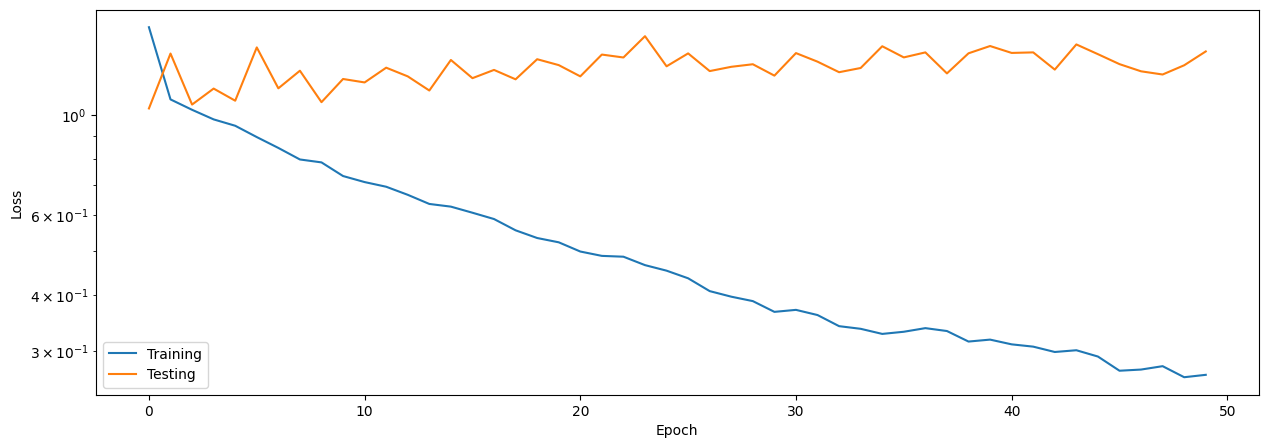

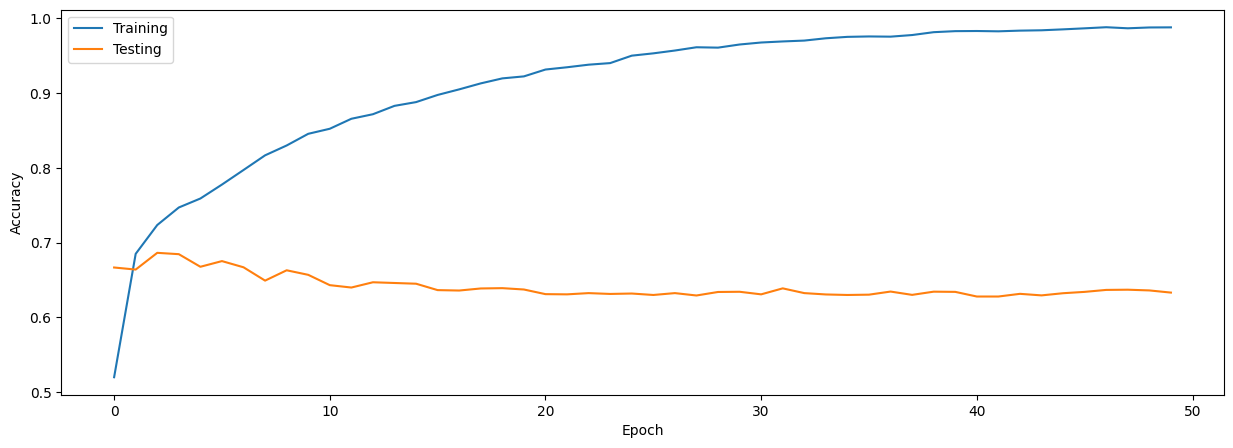

In [10]:
stats.plot(figsize=(15, 5))

In [11]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

In [12]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(6,discretize_step, 40))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 17, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'../gifs/inp{i}.gif', animation.PillowWriter(fps=40), dpi=300)
    out_anim.save(f'../gifs/out{i}.gif', animation.PillowWriter(fps=40), dpi=300)


In [13]:
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'../gifs/inp{i}.gif')
    html += gif_td(f'../gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
